# ***Informacion del dataset***

In [21]:

%%html
<style> table { display: inline-block  }</style>

https://www.kaggle.com/datasets/riteshahlawat/covid19-mexico-patient-health-dataset



|col|0|1|97-98|
|---|---|---|---|
|sex|F|M|?|
|hospitalized|no|si|?|
|intubated|no|si|?|
|pneumonia|no|si|?|
|age|no|si|?|
|pregnant|no|si|?|
|diabetes|no|si|?|
|copd|no|si|?|
|asthma|no|si|?|
|immunosuppression|no|si|?|
|hypertension|no|si|?|
|other_diseases|no|si|?|
|cardiovascular|no|si|?|
|obesity|no|si|?|
|chronic_kidney_failure|no|si|?|
|smoker|no|si|?|
|another_case|no|si|?|
|outcome|no|si|?|
|icu|no|si|?|
|dead|no|si|?|

# **1. Importación de *modules***

In [3]:
import numpy as np
import pandas as pd

import re

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings("ignore")

import funciones as f

# **2. Importación del dataset *Patient.csv***


In [4]:
data_raw = pd.read_csv("../data/patient.csv", sep = ",", low_memory=False) 
#data.head(3)
#data_raw.shape
f._get_info(data_raw)

(95839, 20)


# **3. Tratamiento de los datos**

## **3.2. Limpieza e imputaciones**

In [ ]:
data_raw["dead"]=data_raw["dead"].replace({"9999-99-99": 1})
data_raw.loc[old_data['dead'] != 1, 'dead'] = 0



### 3.2.1. Dropeo de columnas no informativas

### 3.2.8. Ploteo de correlación entre variables

<Figure size 1224x504 with 0 Axes>

<AxesSubplot:>

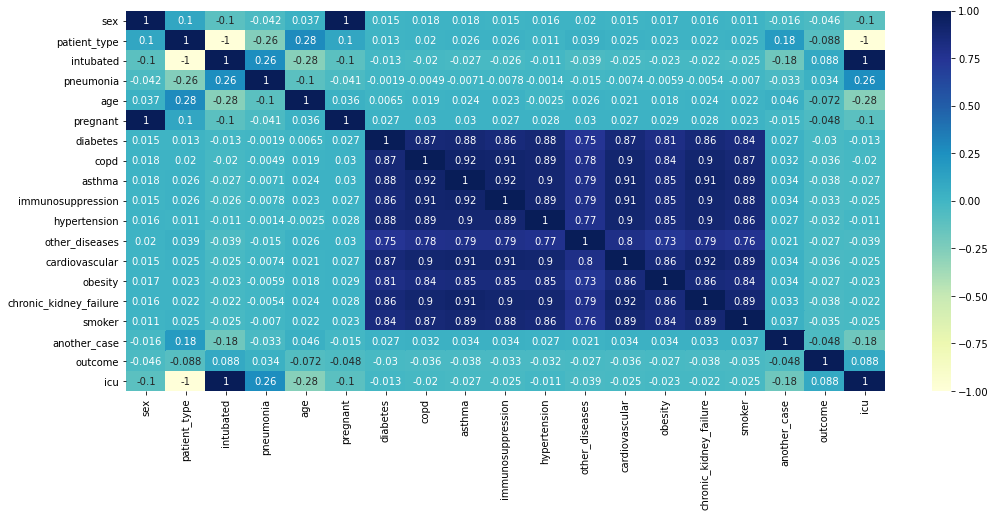

In [5]:
plt.figure(figsize=(17,7))
sns.heatmap(data_raw.corr(), vmin = -1, vmax = 1, center = 0, cmap = "YlGnBu", annot = True)

 <font color='red'>ICU y Intubated son iguales. hay que eliminar ICU</font> 

# **4. Exportación del dataset resultante a un nuevo *.csv***